In [1]:
#Setting API Keys and Env Variables

import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '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'
os.environ['GROQ_API_KEY'] = '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'

# Query Decomposition/Analysis/Transformation: Multi-Query

In [2]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2"))

retriever = vectorstore.as_retriever()

/home/nomad/Desktop/WideconsPrototypes/LLM/LLMvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Visualizing all Documents in Vector Store as 2D chart

In [3]:
#Retrieving all VectorStore Docs and checking if they are equal as the one we loaded
DocsAll = vectorstore.get()["documents"]

len(vectorstore.get()["documents"]) == len(splits)

True

In [4]:
DocsAll

['},\n #  … same conversation as earlier, ended with "Make your own assumptions and state them explicitly before starting".\n  {\n    "role": "assistant",\n    "content": "Assumptions:\\n1. Model: The model will contain the game\'s data, such as level information, character states, and enemy positions.\\n2. View: The view will handle the game\'s visuals, including rendering the game objects, backgrounds, and updating the display.\\n3. Controller: The controller will manage user input, such as keyboard controls, and update the model accordingly.\\n\\nWith these assumptions in mind, is there any specific aspect of the keyboard control implementation you would like me to clarify?"\n  },\n  {\n    "role": "user",',
 'Given the user request and the call command, the AI assistant helps the user to select a suitable model from a list of models to process the user request. The AI assistant merely outputs the model id of the most appropriate model. The output must be in a strict JSON format: "i

In [5]:
#Defining Embedding Model and Generating Embedding of all Docs
from sentence_transformers import SentenceTransformer 

Embedder = SentenceTransformer(model_name_or_path = "sentence-transformers/all-mpnet-base-v2")

/home/nomad/Desktop/WideconsPrototypes/LLM/LLMvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
EmbeddedDocs = [Embedder.encode(doc) for doc in DocsAll]

In [7]:
#Ensuring Embedded Docs are same length of Raw Docs and they are all of same Dimension
assert len(EmbeddedDocs) == len(DocsAll)
assert sum([len(EmbeddedDocs[0]) == len(EmbeddedDoc) for EmbeddedDoc in EmbeddedDocs]) == True*len(EmbeddedDocs)

In [8]:
#Using PCA for Dimensionality Reduction of Embeddings that are previously Scaled with StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
import numpy as np

PrincipalComponentAnalysis = PCA(n_components=2)
Scaler = SS()

EmbeddedDocsNP = np.array(EmbeddedDocs)

ScaledEmbeddedDocs = Scaler.fit_transform(EmbeddedDocsNP)

ScaledDecomposedEmbeddedDocs = PrincipalComponentAnalysis.fit_transform(ScaledEmbeddedDocs)

In [9]:
ScaledDecomposedEmbeddedDocs

array([[ 11.201713  ,  -3.618567  ],
       [  0.63096106,  -4.4316216 ],
       [ -8.815239  ,  -7.746452  ],
       [ -0.5891706 ,  17.272825  ],
       [ -9.620427  ,  -9.387682  ],
       [ 14.445386  ,   0.7863873 ],
       [ 23.888123  ,  -5.311518  ],
       [ 12.816062  ,  14.018353  ],
       [  1.4442377 ,  16.353289  ],
       [ -6.4964943 ,   5.666883  ],
       [ -0.38071314,  -6.7708077 ],
       [  8.834147  ,   4.1594853 ],
       [ 20.308062  ,  -4.19903   ],
       [  6.9895334 ,  -9.33569   ],
       [ -8.356081  ,   1.9517504 ],
       [ -9.983799  ,  -3.2456646 ],
       [ -7.898475  ,  -5.7874875 ],
       [ -7.8649826 ,  11.826801  ],
       [ 10.551652  ,  -6.3953786 ],
       [ -0.2823613 ,  -1.9064294 ],
       [-11.786966  ,  -0.85775876],
       [ -4.3602624 ,   5.838067  ],
       [ -4.235352  ,  -7.4437294 ],
       [  0.33694607,  15.665532  ],
       [-10.508122  ,  -5.874955  ],
       [ 22.789576  ,  -3.779184  ],
       [ -9.4727545 ,  10.734393  ],
 

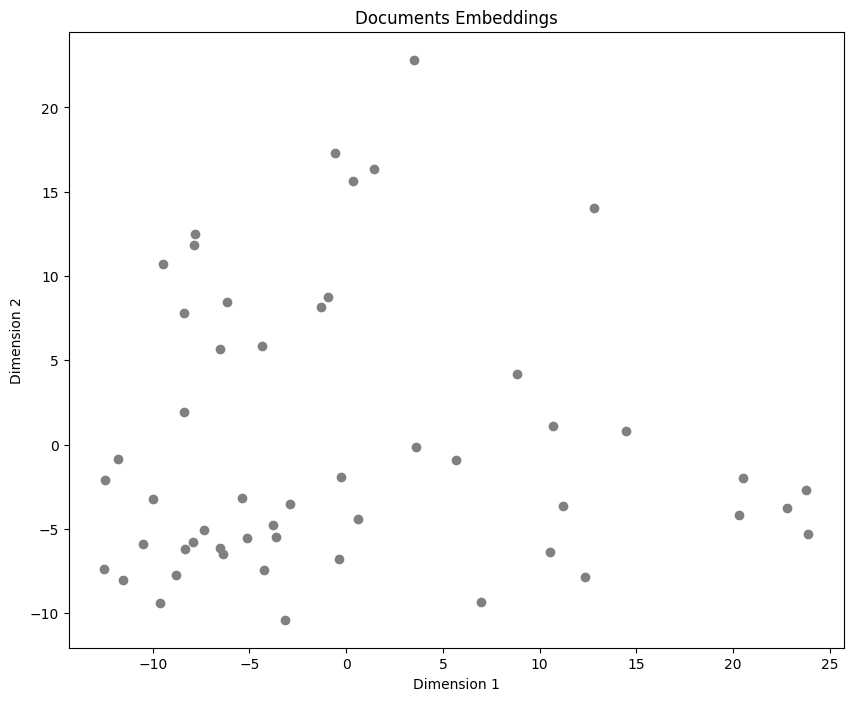

In [10]:
#Plotting the 2D Embeddings Scaled and Decomposed Embeddings

import matplotlib.pyplot as plt
%matplotlib inline

FinalEmbeddings = ScaledDecomposedEmbeddedDocs

fig = plt.figure(figsize=(10, 8))
plt.scatter(x = FinalEmbeddings[:, 0], y = FinalEmbeddings[:, 1], color = "grey")
plt.title('Documents Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

[[-4.2789755  -0.46940342]]


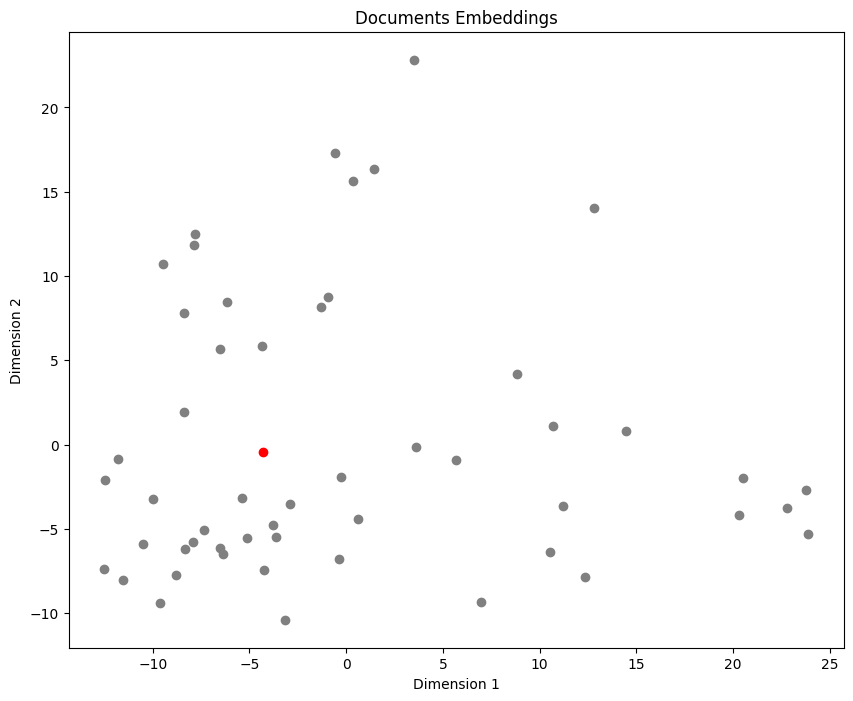

In [11]:
#Putting it all together -> now, given a new question, we embed it and see where is in the 2D plane

#Defining a Function for "Pipelining" the process -> Question -> Embeddings -> Scaling -> Decomposing <- Returned valued 2D final Array

def Pipe(query, embedder, ss, pca):
    EmbeddedQuery = embedder.encode(query)
    EmbeddedQueryNP = np.array(EmbeddedQuery)
    EmbeddedQueryNP = EmbeddedQueryNP.reshape(1, -1)
    ScaledEmbeddedQuery = ss.transform(EmbeddedQueryNP)
    ScaledDecomposedEmbeddedQuery = pca.transform(ScaledEmbeddedQuery)

    return ScaledDecomposedEmbeddedQuery

question = "What is task decomposition for LLM agents?"

TransformedQuery = Pipe(question, Embedder, Scaler, PrincipalComponentAnalysis)

print(TransformedQuery)
    
#len(EmbeddedQuery)

#Now, Plotting it all Together

FinalDocsEmbeddings = ScaledDecomposedEmbeddedDocs

fig = plt.figure(figsize=(10, 8))
plt.scatter(x = FinalDocsEmbeddings[:, 0], y = FinalDocsEmbeddings[:, 1], color = "grey")
plt.scatter(x = TransformedQuery[:, 0], y = TransformedQuery[:, 1], color = "red")
plt.title('Documents Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [12]:
#Moving on, we want to see the difference into our retrieval Mechanism and which are the Closest Docs to our Query.
#To do so, we'll measure Euclidean Distance, Cosine Similarity on the top k=3 docs

k = 3

#print(TransformedQuery)
#print(FinalDocsEmbeddings)

import math

#Returns the Euclidean Distance Between 2 Vectors (We assume they are 2D)
def EuclideanDistance(Vec1, Vec2):
    return np.sqrt(np.sum(np.square(Vec1-Vec2)))

Distances =  []

for Doc in FinalDocsEmbeddings:
    Distances.append(EuclideanDistance(TransformedQuery, Doc))

Distances = np.array(Distances)

#We'll now use np.argpartition to find the indeces of the smallest values
SmallestKIdxs = Distances.argpartition(k)[:k]

#print(Distances)
#print(SmallestKIdxs)
#print(Distances[SmallestKIdxs])

ClosestDocsToQuery = FinalDocsEmbeddings[SmallestKIdxs]
print(ClosestDocsToQuery)

[[-5.362845  -3.1546488]
 [-2.8831146 -3.498716 ]
 [-0.2823613 -1.9064294]]


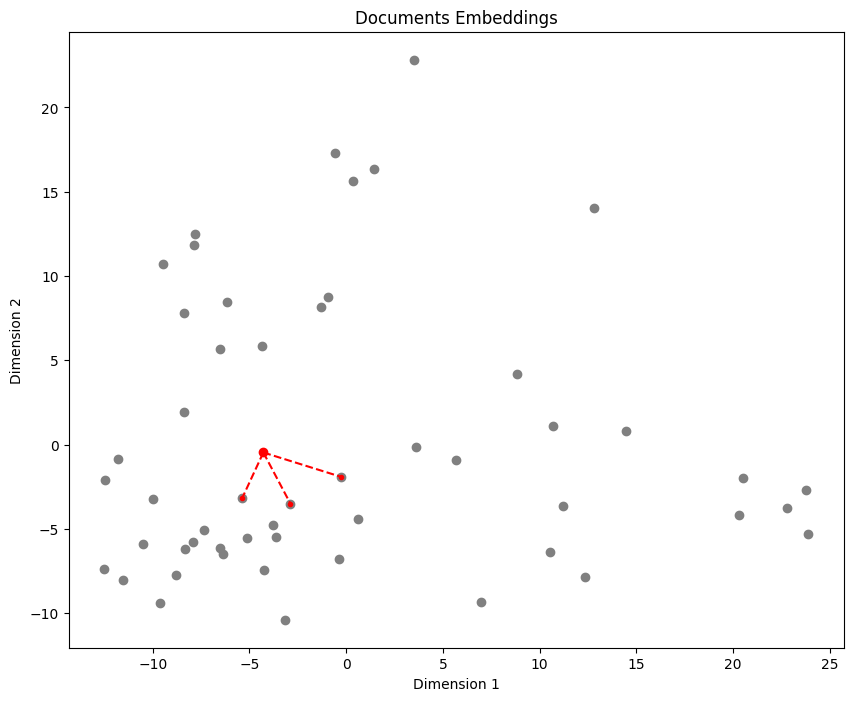

In [13]:
#Let's Plot them again highlighting the closest Docs to our Query

fig = plt.figure(figsize=(10, 8))
plt.scatter(x = FinalDocsEmbeddings[:, 0], y = FinalDocsEmbeddings[:, 1], color = "grey")
plt.scatter(x = TransformedQuery[:, 0], y = TransformedQuery[:, 1], color = "red")
plt.plot(ClosestDocsToQuery[:,0], ClosestDocsToQuery[:,1], marker='o', markersize=3, color='red', linestyle='none')
#plt.plot(TransformedQuery, [x], linestyle = '--', color = 'red')

for x in ClosestDocsToQuery:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'red')

plt.title('Documents Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [14]:
#Now, we'll calculate Cosine Similarity

from numpy.linalg import norm as Norm

k = 3

#Given 2 (Assumed 2D Arrays) Return their Cosine Similarity
def CosineSimilarity(Vec1, Vec2):
    return np.dot(Vec1,Vec2)/(Norm(Vec1)*Norm(Vec2))

Similarities =  []

for Doc in FinalDocsEmbeddings:
    Similarities.append(CosineSimilarity(TransformedQuery, Doc))

Similarities = np.array(Similarities).reshape(1, -1)[0]

HighestKIdxs = Similarities.argpartition(-k)[-k:]

MostSimilarDocsToQuery = FinalDocsEmbeddings[HighestKIdxs]

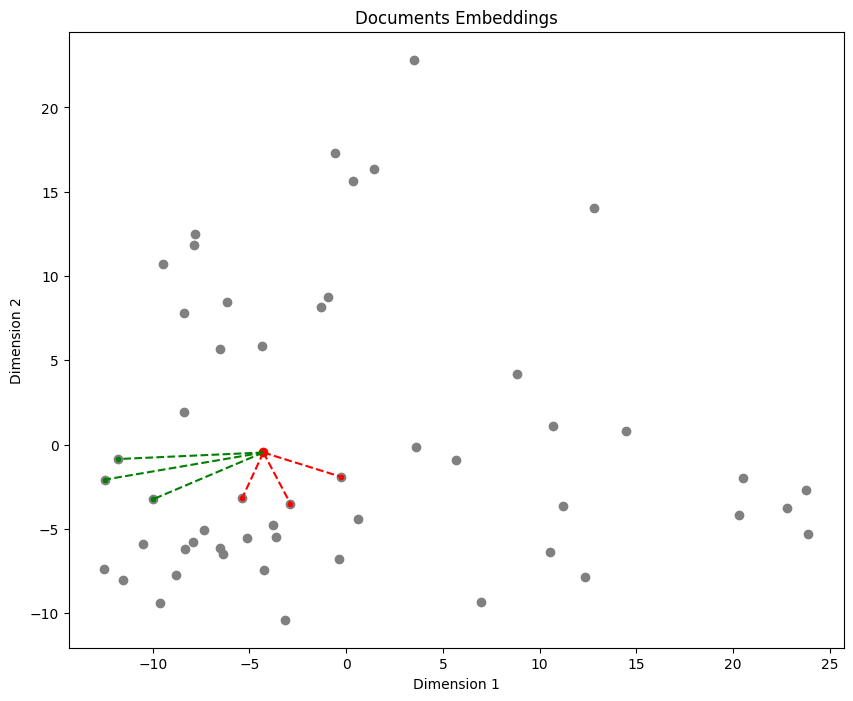

In [15]:
#Let's add to our plot an highlight to the most similar ones in green

fig = plt.figure(figsize=(10, 8))
plt.scatter(x = FinalDocsEmbeddings[:, 0], y = FinalDocsEmbeddings[:, 1], color = "grey")
plt.scatter(x = TransformedQuery[:, 0], y = TransformedQuery[:, 1], color = "red")
plt.plot(ClosestDocsToQuery[:,0], ClosestDocsToQuery[:,1], marker='o', markersize=3, color='red', linestyle='none')
plt.plot(MostSimilarDocsToQuery[:,0], MostSimilarDocsToQuery[:,1], marker='o', markersize=3, color='green', linestyle='none')

for x in ClosestDocsToQuery:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'red')

for x in MostSimilarDocsToQuery:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'green')

plt.title('Documents Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [17]:
#Our Query is not Close to the most similar documents... 
#Let's see which ones the Vector Store will Retrieve and plot them.

Query = "What is task decomposition for LLM agents?"

EmbeddedQuery = Embedder.encode(Query)

#No Need to Embed
RetrievedDocs = vectorstore.search(Query, search_type="similarity", k=3)

#Scaling them and getting them to our plot
#vectorstore.search()

In [21]:
from langchain.load import dumps, loads

flattened_docs = [dumps(doc) for sublist in RetrievedDocs for doc in sublist]
# Get unique documents
unique_docs = list(set(flattened_docs))
# Return
d = [loads(doc) for doc in unique_docs]

In [51]:
CleanedRetrievedDocs = []

for x in d:
    if "page_content" in x:
        CleanedRetrievedDocs.append(x[1:])
    #print(d[0][1:])

CleanedRetrievedDocs

[['Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority

In [55]:
a = ["".join(x) for sublist in CleanedRetrievedDocs for x in sublist]
a

['Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority 

In [61]:
EmbeddedRetrievedDocs = [Embedder.encode(d) for d in a]
EmbeddedRetrievedDocsNP = np.array(EmbeddedRetrievedDocs)
#EmbeddedRetrievedDocsNP = EmbeddedRetrievedDocsNP.reshape(1, -1)
ScaledEmbeddedRetrievedDocs = Scaler.transform(EmbeddedRetrievedDocsNP)
ScaledDecomposedEmbeddedRetrievedDocs = PrincipalComponentAnalysis.transform(ScaledEmbeddedRetrievedDocs)

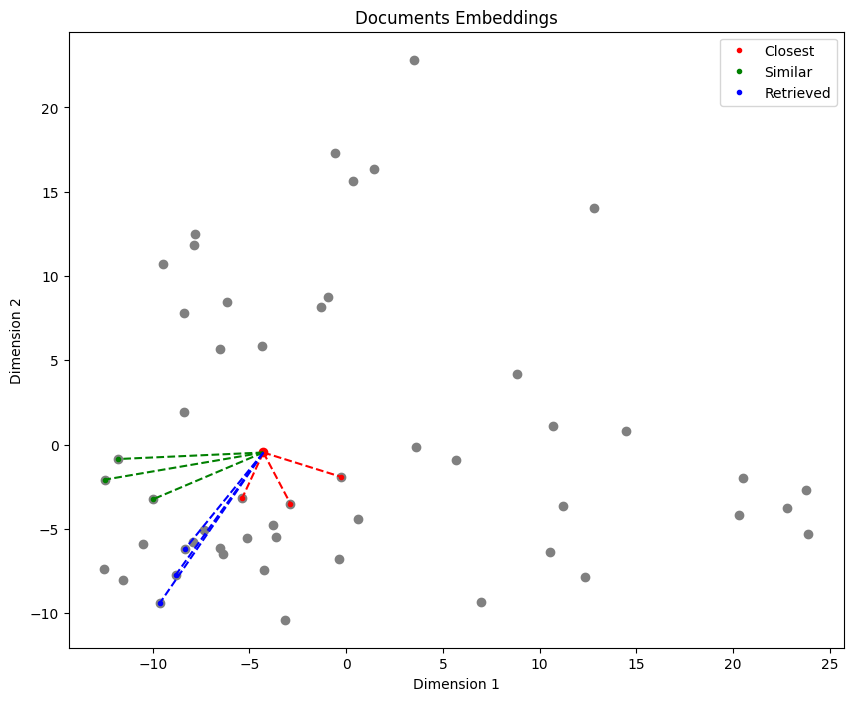

In [80]:
import matplotlib.lines as mlines

fig = plt.figure(figsize=(10, 8))
plt.scatter(x = FinalDocsEmbeddings[:, 0], y = FinalDocsEmbeddings[:, 1], color = "grey")
plt.scatter(x = TransformedQuery[:, 0], y = TransformedQuery[:, 1], color = "red")
closest = plt.plot(ClosestDocsToQuery[:,0], ClosestDocsToQuery[:,1], marker='o', markersize=3, color='red', linestyle='none')
similar = plt.plot(MostSimilarDocsToQuery[:,0], MostSimilarDocsToQuery[:,1], marker='o', markersize=3, color='green', linestyle='none')
retrieved = plt.plot(ScaledDecomposedEmbeddedRetrievedDocs[:,0], ScaledDecomposedEmbeddedRetrievedDocs[:,1], marker='o', markersize=3, color='blue', linestyle='none')

#plt.plot([TransformedQuery[0][0], ScaledDecomposedEmbeddedDoc[0][0]], [TransformedQuery[0][1], ScaledDecomposedEmbeddedDoc[0][1]], linestyle = '--', color = 'blue')

for x in ClosestDocsToQuery:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'red')

for x in MostSimilarDocsToQuery:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'green')

for x in ScaledDecomposedEmbeddedRetrievedDocs:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'blue')


# Additional lines for the legend
extralines = [
    mlines.Line2D([], [], color='red', marker='o', markersize=3, linestyle='none', label='Closest'),
    mlines.Line2D([], [], color='green', marker='o', markersize=3, linestyle='none', label='Similar'),
    mlines.Line2D([], [], color='blue', marker='o', markersize=3, linestyle='none', label='Retrieved')
]

# Create a legend with the combined handles and labels
plt.legend(handles = extralines, loc = 'best')

plt.title('Documents Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
Doc = RetrievedDocs[0]

docstr = str(Doc).replace("page_content=", "").split("metadata")[0].replace("\'", "").replace("\\", "")

In [24]:
docstr

'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority v

In [23]:
docstr = '''Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.','''

In [34]:
ScaledDecomposedEmbeddedDoc in ScaledDecomposedEmbeddedDocs

False

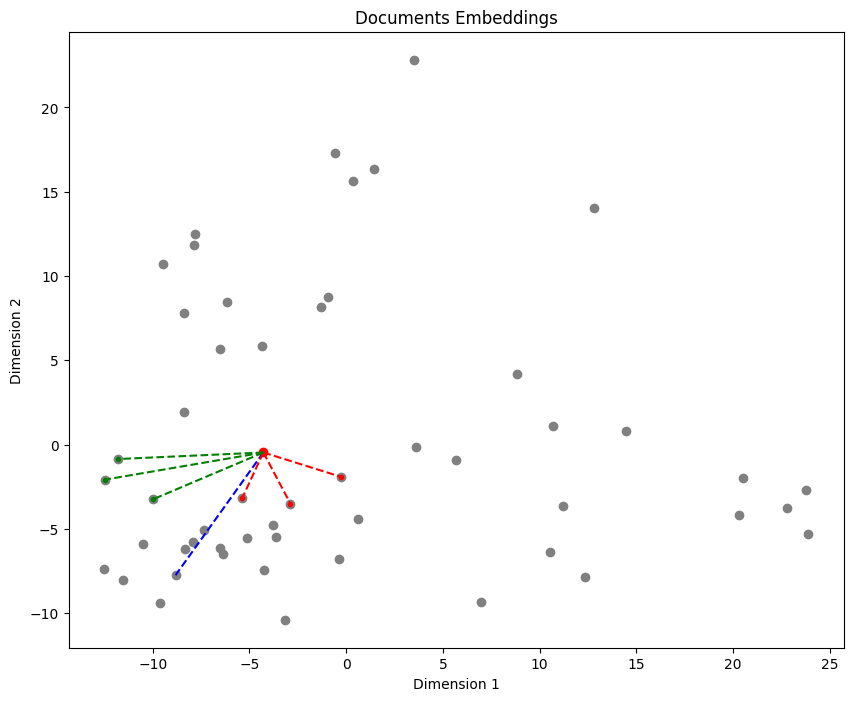

In [35]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(x = FinalDocsEmbeddings[:, 0], y = FinalDocsEmbeddings[:, 1], color = "grey")
plt.scatter(x = TransformedQuery[:, 0], y = TransformedQuery[:, 1], color = "red")
plt.plot(ClosestDocsToQuery[:,0], ClosestDocsToQuery[:,1], marker='o', markersize=3, color='red', linestyle='none')
plt.plot(MostSimilarDocsToQuery[:,0], MostSimilarDocsToQuery[:,1], marker='o', markersize=3, color='green', linestyle='none')
plt.plot([TransformedQuery[0][0], ScaledDecomposedEmbeddedDoc[0][0]], [TransformedQuery[0][1], ScaledDecomposedEmbeddedDoc[0][1]], linestyle = '--', color = 'blue')

for x in ClosestDocsToQuery:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'red')

for x in MostSimilarDocsToQuery:
    plt.plot([TransformedQuery[0][0], x[0]], [TransformedQuery[0][1], x[1]], linestyle = '--', color = 'green')

plt.title('Documents Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
#Euclidean Distance
#np.sqrt(np.sum(np.square(TransformedQuery - FinalDocsEmbeddings[0])))

In [ ]:
#### PROMPTING ####

from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines and do not add anything else, such as introduction or an outro. Only return the 5 New Questions separated by newlines. 
Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq

generate_queries = (
    prompt_perspectives 
    | ChatGroq(model_name="llama3-8b-8192", temperature=1, top_p=1, max_tokens=1024)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [ ]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

In [ ]:
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})

docs[-1]

In [ ]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatGroq(model_name="llama3-8b-8192", temperature=1, top_p=1, max_tokens=1024)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})